<a target="_blank" href="https://colab.research.google.com/github/upadhyan/SUDS-2024-Bootcamp-Friday/blob/main/Unsupervised_Learning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# UofT DSI SUDS
#### Clustering and PCA
#### Teaching team: Teaching team: Nakul Upadhya
##### Lab author: Alexander Olson, aolson@mie.utoronto.ca, edited by Jake Mosseri

In this lab we will examine a number of clustering methods, starting with K-Means. We will also look at dimensionality reduction, covering two ways of visualizing high dimensional datasets. Both of these tasks are examples of _unsupervised learning_: they run without requiring labeled training data. Let's start with K-Means clustering.

## K-Means Clustering

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

The K-Means algorithm identifies a pre-determined number of clusters (K) within an unlabeled dataset. It does this using a simple procedure describing what each cluster should look like:

* Each cluster can be represented by the mean (or centroid) of all the points in that cluster.
* Each point is closer to the mean point (centroid) in its own cluster than to that of any other cluster.

Let's get a visual representation of what this looks like. First we will generate a simple 2D dataset containing four distinct blobs:

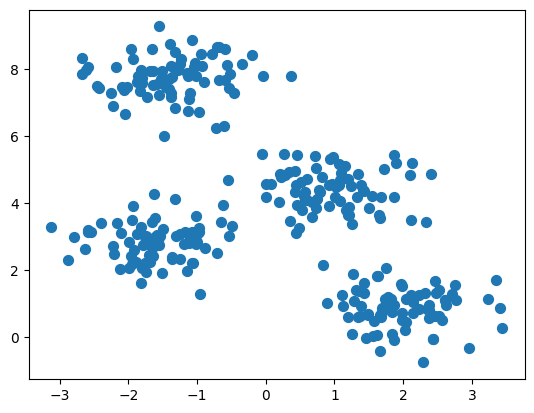

In [2]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0) # Create synthetic data
plt.scatter(X[:, 0], X[:, 1], s=50); # plot the synthetic data

It's pretty easy to tell where the four clusters are by eye, but let's see how K-Means performs at picking them out. We will also indicate the representative point for each cluster (the _cluster centre_).

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


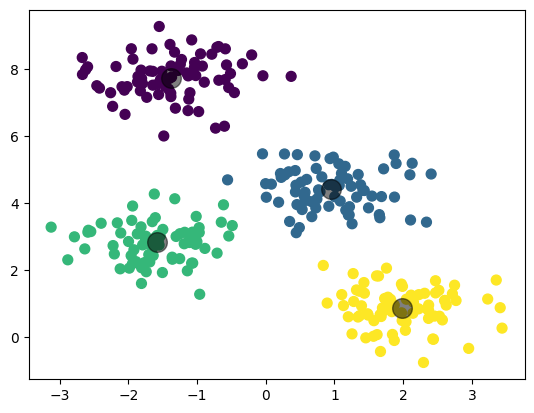

In [3]:
kmeans = KMeans(n_clusters=4) # create the KMeans model. Specify that we want 4 clusters
kmeans.fit(X) # run the clustering
y_kmeans = kmeans.predict(X) # get the cluster labels

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis') # plot the synthetic data colored by cluster
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5); # plot the cluster centers

The good news is that the k-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye. But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly. Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to k-means involves an intuitive iterative approach known as _expectation–maximization_.

## Expectation Maximization

Expectation Maximization (EM) is a powerful algorithm that comes up a lot in different avenues of data science. K-Means is a good example of this algorithm, and we'll go through it briefly here. In short, K-Means consists of the following procedure:

* Guess some cluster centres (at random, or using a heuristic)
* Repeat until convergence (i.e. the clusters stop changing between steps):
    * _E-Step_: Assign each point to the closest cluster centre
    * _M-Step_: Set the cluster centres to the mean

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

The k-Means algorithm is simple enough that we can write it in a few lines of code. The following is a very basic implementation:

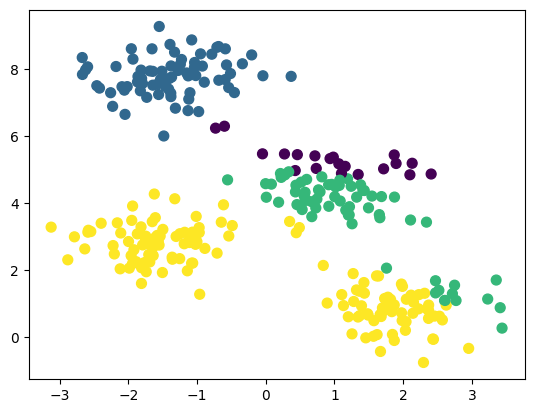

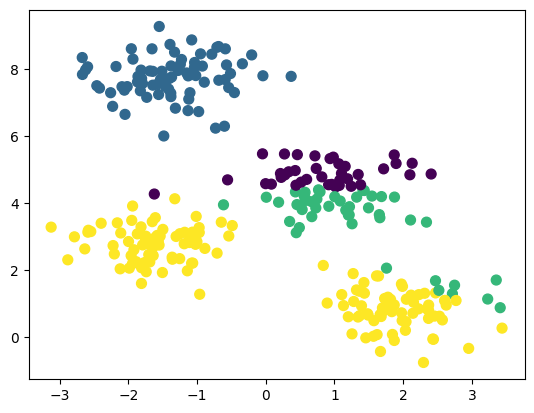

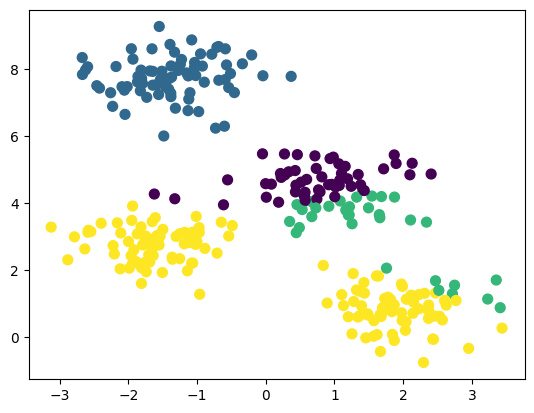

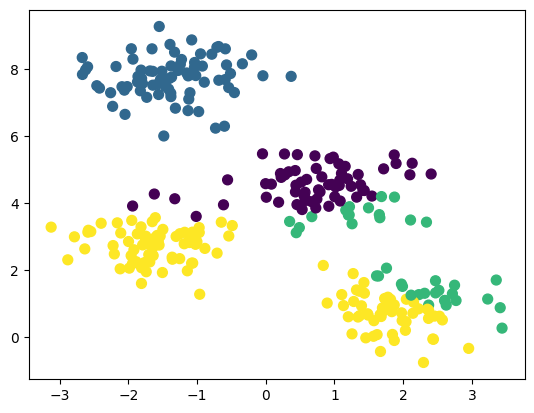

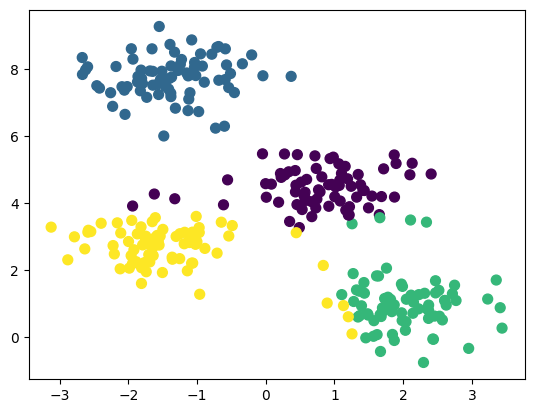

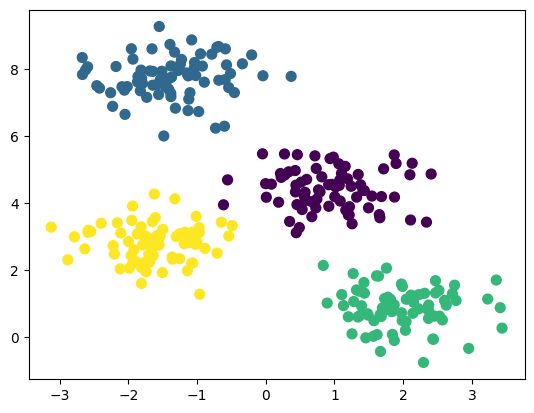

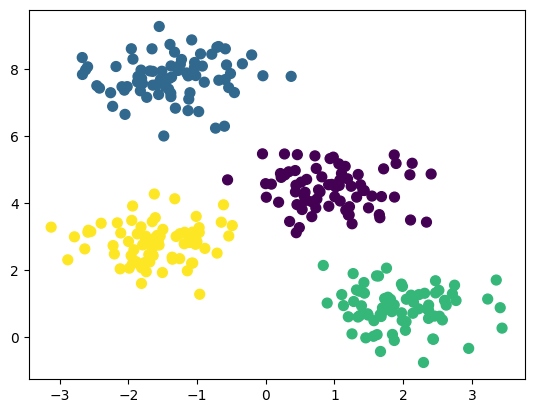

In [4]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break

        centers = new_centers
        plt.scatter(X[:, 0], X[:, 1], c=labels,
                    s=50, cmap='viridis');
        plt.pause(0.05)
    return centers, labels

centers, labels = find_clusters(X, 4)


## Caveats

If K-Means were perfect, we could stop here. But unfortunately, while elegant, this algorithm does come with its own set of problems. For example, the random seed used to initialize the clusters can affect the results - there is no guarantee that the algorithm will find the best _possible_ solution. (For an example of this, try changing the random seed in the previous example to `3`).

Another common problem with K-Means is that you must tell it how many clusters to look for - it cannot learn this from the data. This is fine in simple, low-dimensional examples such as the one above, but when the data is high-dimensional it becomes impossible to eyeball the correct number of clusters for your data. In fact, we can pass any number of clusters to the algorithm and it won't complain:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


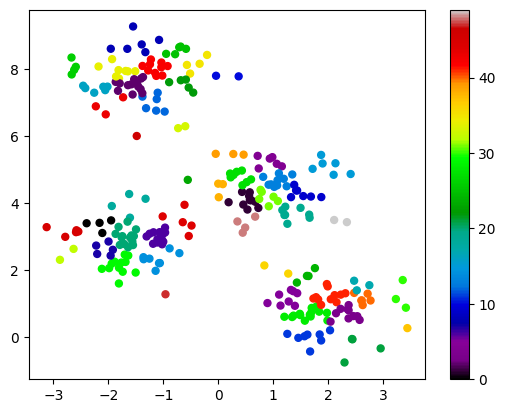

In [5]:
kmeans = KMeans(n_clusters=50)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=25, cmap='nipy_spectral')
plt.colorbar();

Again, this is obviously wrong in this example, but the algorithm has no way of knowing this. However, there *is* a way to identify the best value for K from the data - at least, heuristically.

## Finding the Elbow

If you were tasked with calculating a score that indicates the best possible fit for the data, you might try the average distance for each point in a cluster to its cluster centre. The logic here would be that a better cluster should have all its points close to its centre - hence, the descriptive power of that cluster centre would be higher.

Unfortunately, you may realize, the more clusters there are, the better this score would be. In fact, for N data points, the optimal value would be N=K! At this value, every point would be exactly its cluster centre. But then we aren't really clustering at all!

The point is, as K increases, the average proximity to the cluster centre is _guaranteed_ to increase. But there is still some information we can gain from this metric. While the value itself always increases, the _rate of change_ can differ - and here is the secret to identifying the best value for K.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

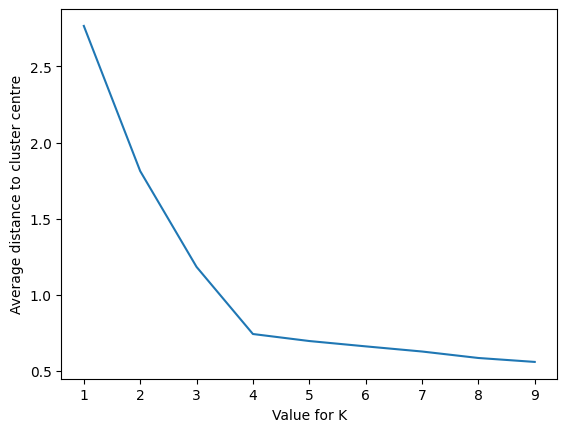

In [6]:
from scipy.spatial.distance import cdist

av_dist = []

for k in range(1,10):
    km = KMeans(n_clusters=k).fit(X)
    av_dist.append(
        sum(
            np.min(
                cdist(X, km.cluster_centers_, 'euclidean'),
                axis=1
            )
        ) / X.shape[0]
    )

plt.plot(range(1,10), av_dist)
plt.xlabel('Value for K')
plt.ylabel('Average distance to cluster centre');

Looking at this graph, it's transparently obvious where the improvement with a higher K stops becoming substantial - K = 4, just as we would expect. If we plot the _improvement_, this transition becomes even more obvious:

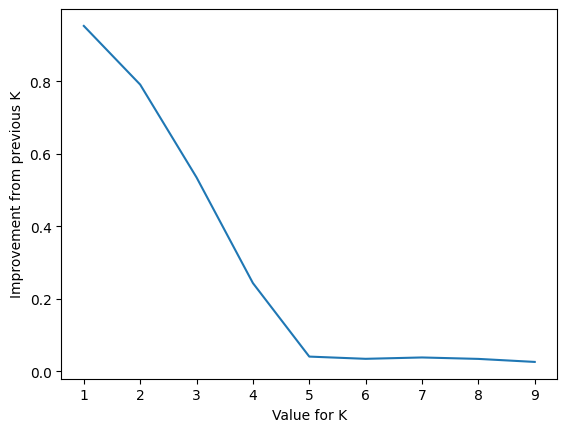

In [7]:
plt.plot(range(1,10),-np.gradient(av_dist))
plt.xlabel('Value for K')
plt.ylabel('Improvement from previous K');

The _elbow_ is the point in the line where improvement transitions from substantial to minimal. Of course, such a clear elbow is not guaranteed - if your dataset doesn't cluster very well, it might be the case that there's no clear transition from good improvement to poor improvement. But in situations where there *is* a good value for K waiting to be found, the Elbow method can help us consistently find it.

Now, you try on the Iris dataset from Lab 1. This data is 4-dimensional, so we can't plot it to quickly find the number of clusters. Instead, we need the Elbow. First, calculate the average distance to cluster centre for a range of K values, then identify the elbow.

**YOUR TURN**
* Using the Iris dataset, and the Elbow technique, identify the best number of clusters and plot a graph showing the elbow.

In [8]:
from sklearn.datasets import load_iris
iris_data = load_iris() # Load the Iris Data
feature_data = iris_data.data # get the features from the data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

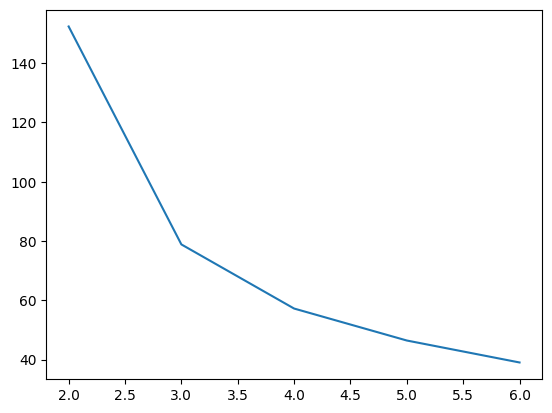

In [10]:
X = feature_data


av_dist = []

for k in range(2,7):
  clust = KMeans(n_clusters = k)
  clust.fit(X)
  av_dist.append(clust.inertia_)

plt.plot(list(range(2,7)), av_dist)

#Insert your code here to identify the best number of clusters


In [ ]:
#Insert your code here to plot a graph showing the elbow

### Dimensionality reduction and principle component analysis

As you get more in-depth in the world of data science, you'll learn that in practice it's very uncommon to work with datasets that are 2 or 3 dimensional, and so can be plotted directly. We're now going to look at _dimensionality reduction_: a category of unsupervised algorithms which attempt to collapse high-dimensional datasets into a low-dimensional space.

Obviously, as suggested above, one reason to do this is to aid visualization. But that's far from the only reason dimensionality reduction is useful! These techniques also allow us to filter noise, extract useful features, and much more.

Let's dive into PCA. We'll first take a two dimensional dataset and reduce it to one dimension.

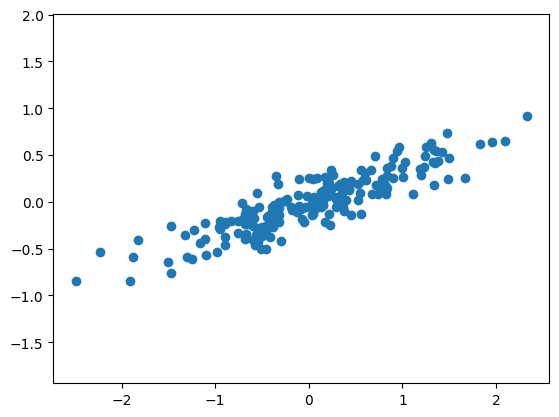

In [11]:
rng = np.random.RandomState(1) # set the random state for reproducability

X = np.dot(rng.rand(2,2),
          rng.randn(2,200)).T # create synthetic data
plt.scatter(X[:,0],X[:,1]) # plot synthetic data
plt.axis('equal');

Here we have a two dimensional dataset that, by eye, has a nearly linear relationship between the X and Y values. This is reminiscent of the type of data we would look to explore with linear regression, but the problem setting here is slightly different: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset. Using Scikit-Learn's PCA estimator, we can compute this as follows:

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X);

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [13]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

In [14]:
pca.explained_variance_

array([0.7625315, 0.0184779])

To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

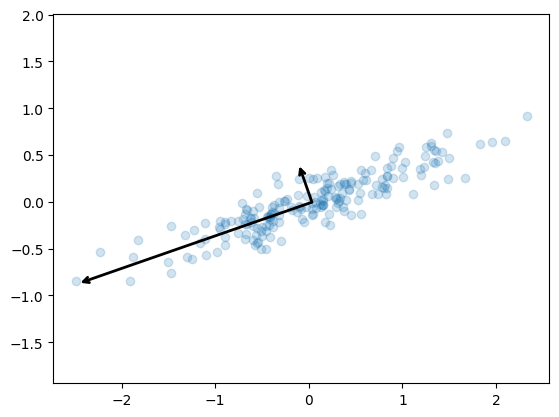

In [15]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the "principal components" of the data.

You have likely noticed that in this example, almost all of the variance is explained by the first axis, while the second axis explains very little variance. This is where PCA becomes a tool for dimensionality reduction. By transforming the data to lie along the PCA dimensions and then only keeping the first K dimensions, we can reduce our dataset into K dimensional space:

original shape:    (200, 2)
transformed shape: (200, 1)


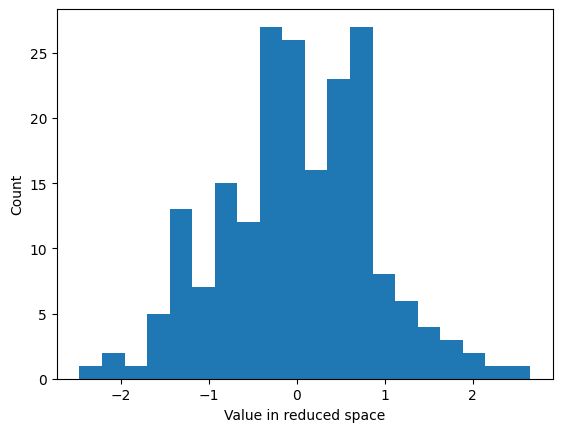

In [16]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
plt.hist(X_pca,bins=20)
plt.xlabel('Value in reduced space')
plt.ylabel('Count');

If we project our new, low-dimensional data back into the original space, we can get a good visual intuition of what PCA has done for us:

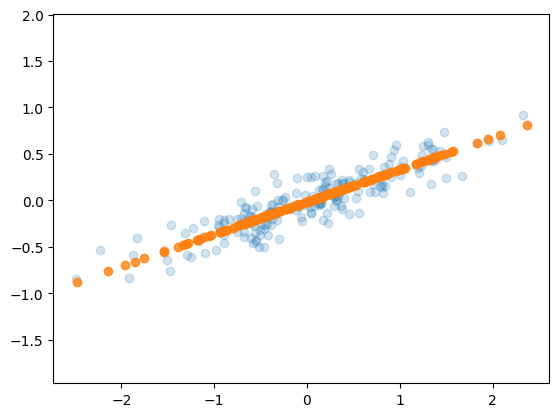

In [17]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the orange points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data. To see this, let's take a quick look at the application of PCA to a much higher dimensional dataset.



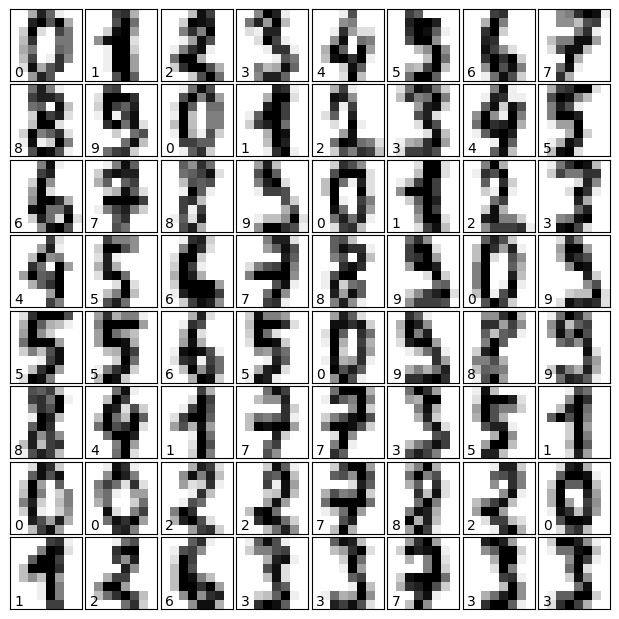

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

This dataset contains a series of hand-written digits, translated to an 8x8 (i.e. 64 dimensional) grid. To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [19]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data) # this is a quicker way to call pca.fit(X) and then pca.transform(X)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


<ipython-input-20-504ece1e58b7>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


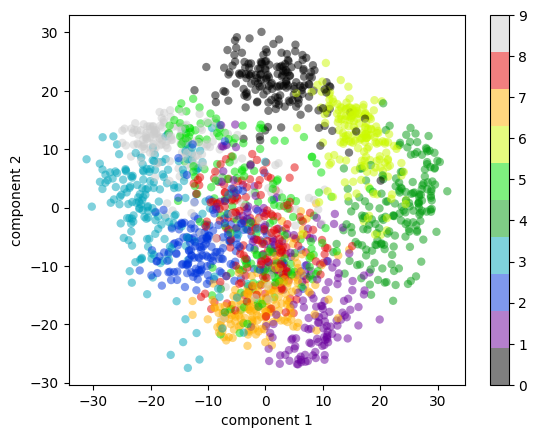

In [20]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

**YOUR TURN**

Load the wine dataset from lab 1-2 and use PCA to reduce its dimensionality to two dimensions. Then, plot the dataset and color each point according to its label.

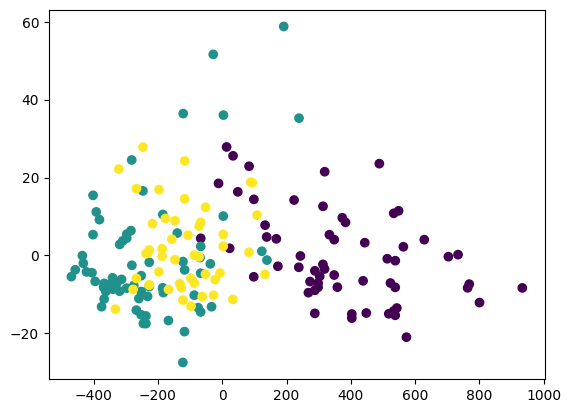

In [21]:
from sklearn.datasets import load_wine

wine_data = load_wine()

feature_data = wine_data.data

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(feature_data)
plt.scatter(X_pca[:,0], X_pca[:,1], c = wine_data.target)

## TSNE

We are now going to look at a different method of dimensionality reduction: t-SNE, a method partially developed here at U of T by Geoffrey Hinton in 2008. It differs from PCA in that it uses the _local relationships_ between points to create a low-dimensional mapping. Among other things, this allows t-SNE to capture non-linear structures in the data.

There are a number of other benefits to t-SNE over PCA, but since we are focusing on using dimensionality reduction for visualization we will stick to the benefits which are apparent in that space. Because t-SNE considers the local relationships between points, it ensures that the distances between points in the low dimensional mapping are representative of the distances in the original space. This makes it a lot more useful for visualization compared to PCA!

### How t-SNE works

t-SNE – at a high level – basically works like this:

Step 1: In the high-dimensional space, create a probability distribution that dictates the relationships between various neighboring points

Step 2: It then tries to recreate a low dimensional space that follows that probability distribution as best as possible.

The “t” in t-SNE comes from the t-distribution, which is the distribution used in Step 2. The “S” and “N” (“stochastic” and “neighbor”) come from the fact that it uses a probability distribution across neighboring points.

Let's look at a more advanced version of the handwritten digits dataset to get a visual sense of how t-SNE and PCA differ. The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset comprises 70,000 handwritten digits taken from the American Census Bureau and labelled by American high school students. It's a benchmark of learning about ML, and as such it's easy to download:

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',cache=False) #This could take a little while - it's a lot of data.
X = mnist['data']
y = mnist['target']
y = [int(t) for t in y]
X.shape

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)

First, we use our knowledge of PCA to reduce MNIST to two dimensions and plot it, color coded by target value.

<ipython-input-4-f9c937f1ebad>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


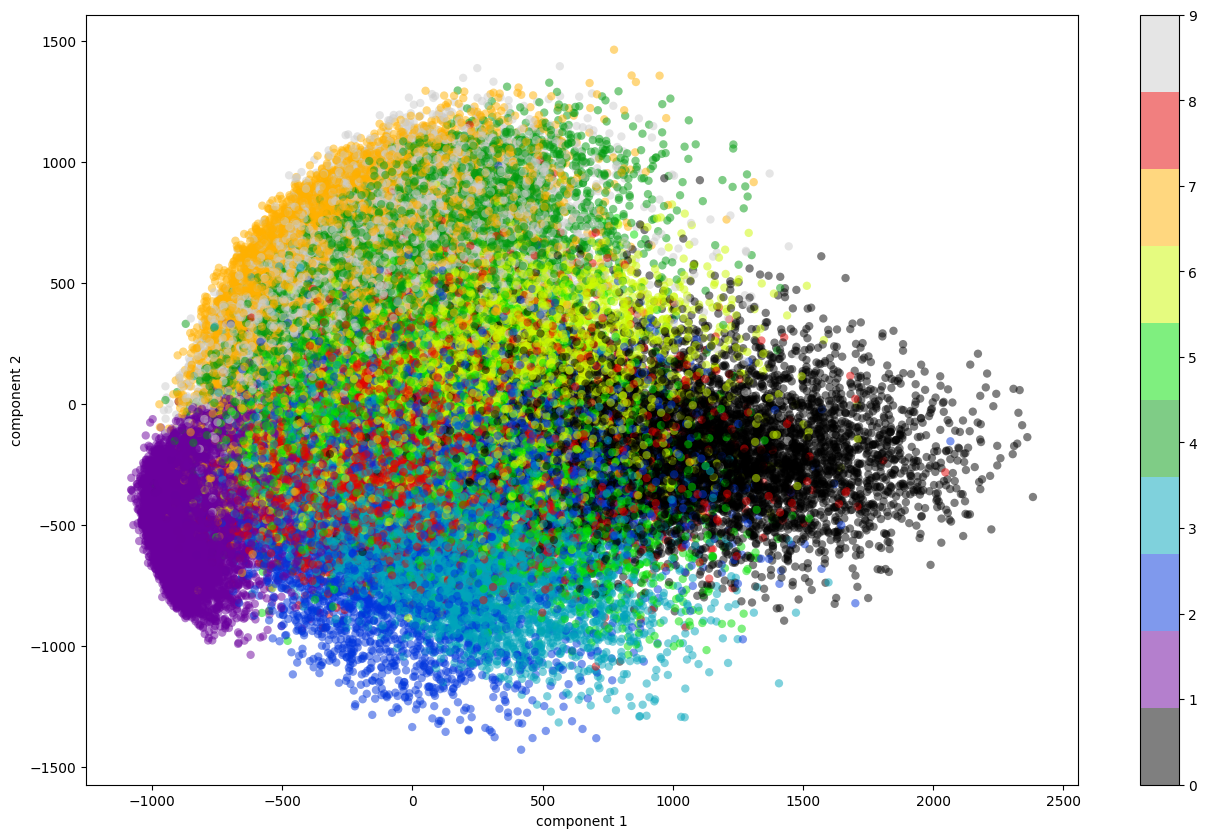

In [4]:
plt.figure(figsize=(16,10));
from sklearn.decomposition import PCA

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X)

plt.scatter(projected[:, 0], projected[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Okay, so that should be similar to what we saw above with the smaller digit dataset, but it's honestly not very useful. Everything is just in a huge, formless blob and we aren't really gathering much information - it's just overwhelming. So let's see what t-SNE can do.

**NOTE** t-SNE is going to take a lot longer to run than PCA. Although you *can* run it on the entire 70,000 image dataset, this could take a significant amount of time even on a high end computer. If you don't want to wait around that long, uncomment the line below to get a random subsample of the data which you can use instead.

In [ ]:
from sklearn.model_selection import train_test_split
#_,X,_,y = train_test_split(X,y,test_size=1/14)

In [5]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.117s...
[t-SNE] Computed neighbors for 70000 samples in 204.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for 

<ipython-input-6-73437b1dd70a>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


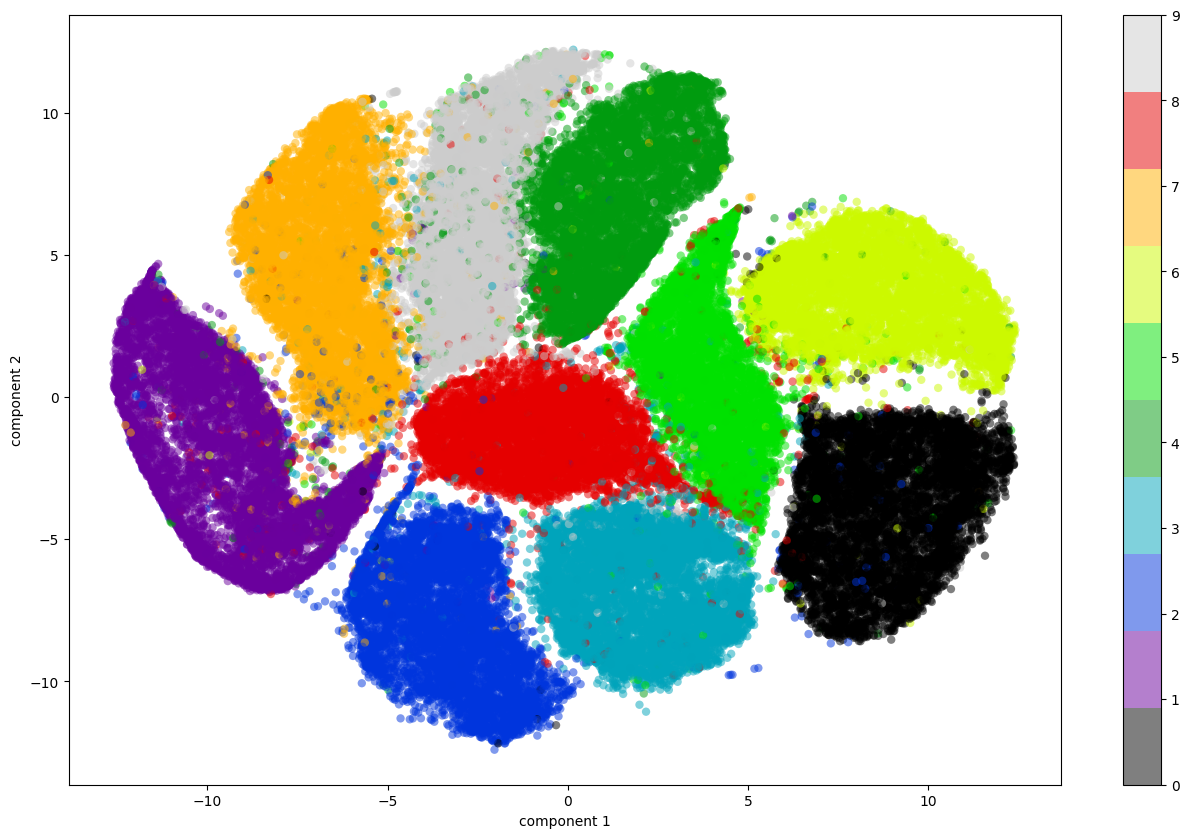

In [6]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Woah! Using t-SNE, the clusters are much more clearly defined, with different numbers being clearly separated in the low dimensional space. Running a clustering algorithm like K-Means now would likely give us pretty reasonable performance on classifying the digits, even just from two dimensions.

Congratulations! You're finished with this lab. For a more detailed introduction to t-SNE which dives into the math behind it, take a look [here](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm).